# GADMA with structure model (momentsLD)

For this example, we will run GADMA with the default structure demographic model using momentsLD engine. Structure defines how detailed the demographic model is and GADMA finds all possible parameters for this model.
For our purposes, we will use simulated YRI CEU two population data.

Parameters, model, and parameter values are taken from the paper "GADMA: Genetic algorithm for inferring demographic history of multiple populations from allele frequency spectrum data" Noskova et al. 2020

All code including the simulation part is presented here. 

In [22]:
import os
import demes
import msprime
import moments.LD
import numpy as np
from gadma import *
from os import path
from gadma.engines.demes_engine import DemesEngine
from gadma.engines.moments_ld_engine import MomentsLdEngine

In [23]:
# Ancestral size 
Nanc = 7220
# mutation rate
mu = 2.35e-8

Create variables for EpochDemographicModel

In [24]:
nu1F = PopulationSizeVariable('nu1F')
nu2B = PopulationSizeVariable('nu2B')
nu2F = PopulationSizeVariable('nu2F')
m = MigrationVariable('m')
d1 = DynamicVariable('d1')
Tp = TimeVariable('Tp')
T = TimeVariable('T')

Values from the original paper

In [25]:
values = {nu1F: 1.881, nu2F: 1.845, nu2B: 0.0710, Tp:  0.355,
          T:  0.111, m: 0.911, d1: 'Exp'}

EpochDemographicModel corresponding to the model from the original paper

In [26]:
model_YRI_CEU = EpochDemographicModel(Nanc_size=Nanc)
model_YRI_CEU.add_epoch(Tp, [nu1F])
model_YRI_CEU.add_split(0, [nu1F, nu2B])
model_YRI_CEU.add_epoch(T, [nu1F, nu2F], [[0, m], [m, 0]], ["Sud", d1])

Now we can set our model for the DemesEngine draw plot and generate code for further msprime simulation

In [27]:
engine = DemesEngine()
engine.model = model_YRI_CEU
engine.data_holder = VCFDataHolder
engine.data_holder.population_labels = ["YRI", "CEU"]
engine.draw_schematic_model_plot(values, save_file="demes_YRI_CEU_plot.png", );
engine.generate_code(values, filename=f"./YRI_CEU", nanc=7220)

Demes visualization of simulated model

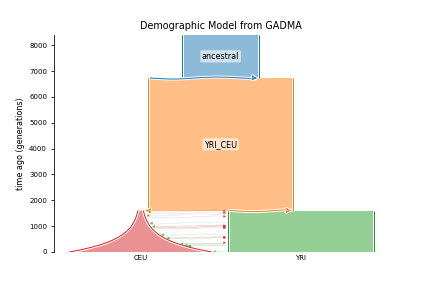

In [28]:
from IPython.display import Image
from IPython.core.display import HTML 

Image("demes_YRI_CEU_plot.png")

## Data simulation using demes and msprime

Using code generated in previous steps we start msprime simulation. We create 100 vcf files, because we want to use 100 regions in our further analysis. Each repeat differs a little from others and represents one single chromosome. 

In [29]:
g = demes.load(f"./YRI_CEU.yml")
demog = msprime.Demography.from_demes(g)
num_reps=100
L=1000000
u=mu
r=1.5e-8
n=10
tree_sequences = msprime.sim_ancestry(
    {"YRI": n, "CEU": n},
    demography=demog,
    sequence_length=L,
    recombination_rate=r,
    num_replicates=num_reps,
    random_seed=42,
)
if not path.exists("./data"):
    os.mkdir("./data")
for jj, ts in enumerate(tree_sequences):
    ts = msprime.sim_mutations(ts, rate=u, random_seed=jj + 1)
    vcf_name = f"./data/YRI_CEU_{jj + 1}.vcf"
    with open(vcf_name, "w+") as fout:
        ts.write_vcf(fout)

Create recombination maps and population maps. In this step we can choose one of two options: create one file, containing all recombination maps or create 100 recombination maps (one for each chromosome). I use the second option because it's easier than the first.

In [30]:
for ii in range(100):
    with open(f"./data/rec_maps/flat_map_{ii + 1}.txt", "w+") as fout:
        fout.write("pos\tMap(cM)\n")
        fout.write("0\t0\n")
        fout.write(f"{L}\t{r * L * 100}\n")

with open("./data/samples.txt", "w+") as fout:
    fout.write("sample\tpop\n")
    pops = ["YRI", "CEU"]
    for jj in range(2):
        for ii in range(n):
            fout.write(f"tsk_{jj * n + ii}\t{pops[jj]}\n")

GADMA takes only one single vcf file as input. We need to rename our chromosomes to have different names and concat them to one file.

In [ ]:
for ii in range(1, 101):
    os.system(f"touch ./data/name_{ii}.txt")

    with open(f"./data/name_{ii}.txt", "w") as file:
        file.write(f"1\t{ii}")

    os.system(f"bcftools annotate --rename-chrs ./data/name_{ii}.txt "\
              f"./data/YRI_CEU_{ii}.vcf > ./data/YRI_CEU_{ii}r.vcf")
    os.system(f"rm ./data/YRI_CEU_{ii}.vcf")
    os.system(f"rm ./data/name_{ii}.txt")

os.system(f"bcftools concat ./data/*.vcf > ./data/YRI_CEU_sim_data.vcf")
for ii in range(1, 101):
    os.system(f"rm ./data/YRI_CEU_{ii}r.vcf")

At this step, we have YRI_CEU_sim_data.vcf, popmap, and recombination maps. Let's create a params file.

In [ ]:
with open(f"./data/params_{ii}.txt", "w") as params_file:
    params_file.write(f"Input data : ./YRI_CEU_sim_data, ./samples.txt\n")
    params_file.write("Engine : momentsLD\n")
    params_file.write("ancestral_size_as_parameter: True\n")
    params_file.write("recombination_maps: ./rec_maps\n")
    params_file.write("Mutation rate: 1.5e-8\n")
    params_file.write("Number of repeats : 6\n")
    params_file.write("Number of processes : 6\n")
    params_file.write("region_len: 1000000\n")
    params_file.write(f"Output directory : output_YRI_CEU\n")

We want to separate parsing ld statistics and the main part of gadma works. We can use gadma-parsing_ld_stats and precompute our data before gadma launch

In [ ]:
%%bash
gadma-parsing_ld_stats -p ./data/params 

When all data is precomputed GADMA will update our params file and create a binary file with precomputed ld stats. 

In [5]:
%%bash
cat ./data/params

Input data : ./YRI_CEU_sim_data.vcf, ./samples.txt
Engine : momentsLD
initial_structure: 2,1
Output directory : output_YRI_CEU_resume
ancestral_size_as_parameter: True
recombination_maps: ./rec_maps
Mutation rate: 2.35e-8
Number of repeats : 6
Number of processes : 6
draw_models_every_n_iteration: 100
region_len: 1000000
Symmetric migrations: True
ld_kwargs: {"report": True}
Sequence_length: 1000000
preprocessed_data: ./preprocessed_data.bp


We don't need to change any setting in params file we can launch gadma with the same arguments. 

In [ ]:
%%bash
gadma -p ./data/params 

In [3]:
%%bash
# GADMA.log contains the same output we have during run. Let us see last lines again:
tail -n 20 ./data/GADMA_doc.log

Run 5	-95.95	[ [Nanc = 7729],	[ 2806.556(t1), [2745.65(nu11)], [Exp(dyn11)] ],	[ 1 pop split   75.45% (s1) [2071.542(s1*nu11), 674.108((1-s1)*nu11)] ],	[ 2169.764(t2), [15377.474(nu21), 5530.813(nu22)], [[0, 6.70e-05(m2_12)], [6.70e-05(m2_12), 0]], [Sud(dyn21), Lin(dyn22)] ] ]	f	
Run 2	-141.34	[ [Nanc = 7985],	[ 2844.141(t1), [1535.839(nu11)], [Exp(dyn11)] ],	[ 1 pop split   13.19% (s1) [202.501(s1*nu11), 1333.338((1-s1)*nu11)] ],	[ 3666.04(t2), [15732.236(nu21), 3193.998(nu22)], [[0, 9.21e-05(m2_12)], [9.21e-05(m2_12), 0]], [Sud(dyn21), Sud(dyn22)] ] ]	f	
Run 4	-191.74	[ [Nanc = 6750],	[ 2101.89(t1), [589.234(nu11)], [Lin(dyn11)] ],	[ 1 pop split   63.02% (s1) [371.318(s1*nu11), 217.916((1-s1)*nu11)] ],	[ 1221.031(t2), [11515.474(nu21), 181624.759(nu22)], [[0, 5.70e-05(m2_12)], [5.70e-05(m2_12), 0]], [Sud(dyn21), Exp(dyn22)] ] ]	f	
Run 3	-244.30	[ [Nanc = 9752],	[ 3755.298(t1), [7740.985(nu11)], [Lin(dyn11)] ],	[ 1 pop split   0.10% (s1) [7.741(s1*nu11), 7733.244((1-s1)*nu11)] ],	[ 22

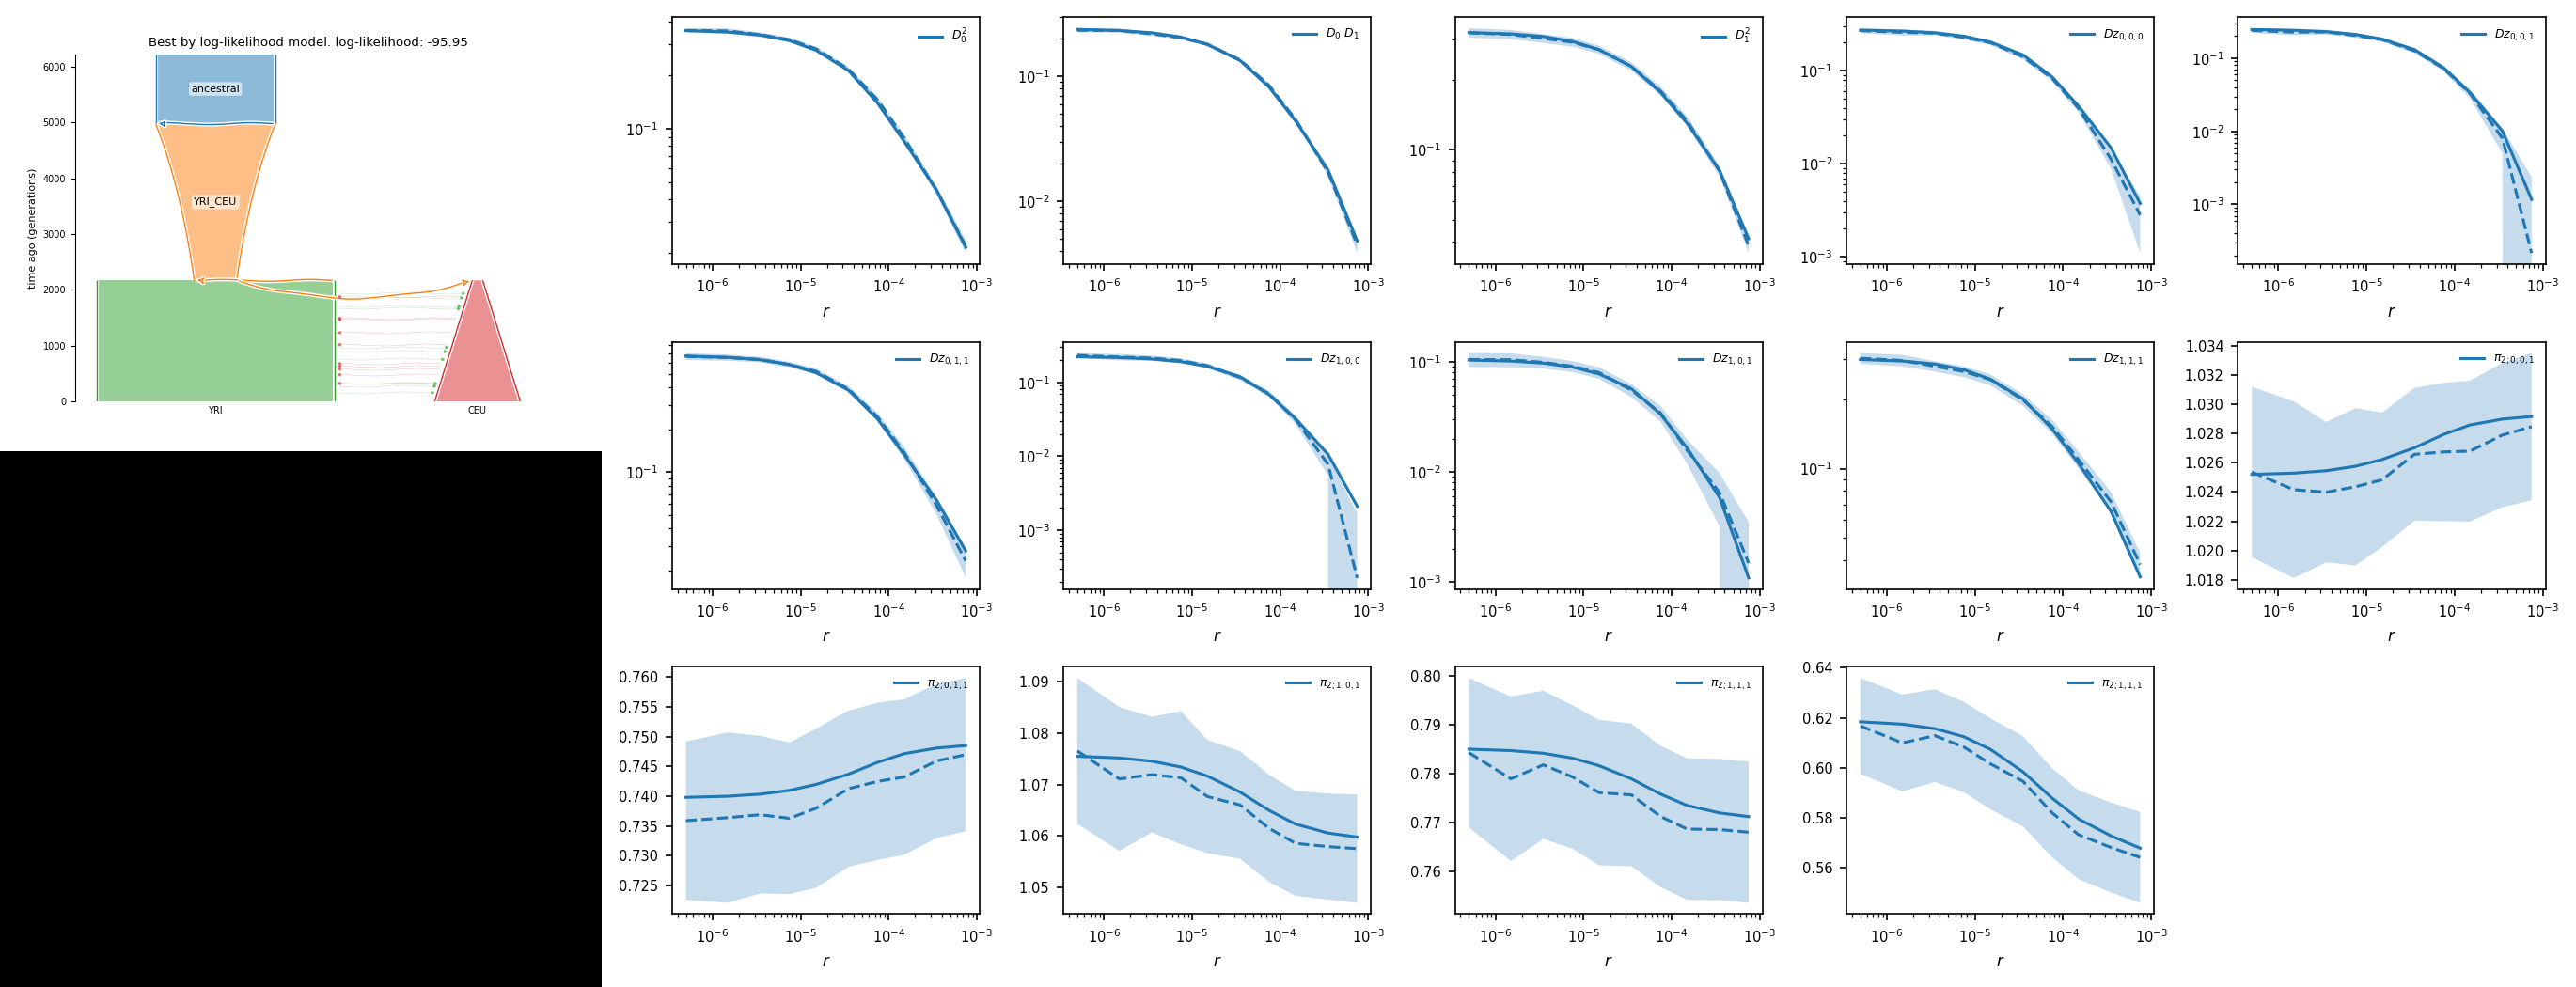

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image("./output_YRI_CEU/best_logLL_model.png")

### Code generation
As with other engines, GADMA will generate code that you can use.

In [2]:
%%bash
cat ./output_YRI_CEU/best_logLL_model_momentsLD_code.py | head -20

import moments.LD
import numpy as np
import pickle
import copy


def model_func(params, rho=None, theta=0.001):
    t1, nu11, s1, t2, nu21, nu22, m2_12 = params
    Nanc = 1.0 #This value can be used in splits with fraction variable
    Y = moments.LD.Numerics.steady_state(rho=rho, theta=theta)
    Y = moments.LD.LDstats(Y, num_pops=1, pop_ids=['YRI', 'CEU'])
    nu1_func = lambda t: Nanc * (nu11 / Nanc) ** (t / t1)
    Y.integrate(tf=t1, nu=lambda t: [nu1_func(t)], rho=rho, theta=theta)
    Y = Y.split(0)
    nu2_func = lambda t: ((1 - s1) * nu11) + (nu22 - ((1 - s1) * nu11)) * (t / t2)
    migs = np.array([[0, m2_12], [m2_12, 0]])
    Y.integrate(tf=t2, nu=lambda t: [nu21, nu2_func(t)], m=migs, rho=rho, theta=theta)
    return Y


